## Half and Half Predictions


In [11]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

path_data = "ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

seed = 777
random.seed(seed)

In [12]:
# Memory reduction code
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:

def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()

## Setting up Time stamp alignment
The weather data is attached to different sites and tied to local time. This leads to temperature peaks at odd times. Here I am adjusted peak temperature to 1500 to align the weather data.

In [14]:
weather_train = pd.read_csv(path_weather_train,  parse_dates=['timestamp'])
weather_test = pd.read_csv(path_weather_test,  parse_dates=['timestamp'])
weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

In [15]:
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23).
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 15, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 15)
site_ids_offsets.index.name = 'site_id'

#Function to align timestamp based on the offsets.
def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    df['timestamp'] = df['timestamp'].astype('str')
    del df['timestamp_aligned']
    del df['offset']
    return df

In [16]:
df_train = pd.read_csv(path_train)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train,  parse_dates=['timestamp'])


In [17]:
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

In [18]:
df_train = reduce_mem_usage(df_train, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
#weather_train = reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%


# Prepare Train Data
The below function does a few feature engineering steps in creating the training dataset:

1. Align the weather data by timestamp. Interpolate nan values in weather dataset
2. Merge building metadata and weather data to training set to create one large dataset
3. Convert timestamp field to pandas datetime object to create time based features
4. Log + 1 transform on building squarefoot field
5. Sort values by timestamp
6. Remove the first section of 0 data for the site 1 buildings in the training set. 
7. Creation of time features: hour, day of the week, weekend indicator based on a corresponding list of major US holidays.
8. Drop timestamp and certain weather features that don't seem to be useful
9. Log + 1 transform on meter readings(target) to reduce effect of outliers during training
10. For the LGBM model, I will not impute NaN values as the model is good at dealing with those without imputation

In [19]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    weather_data = timestamp_align(weather_data)
    weather_data = weather_data.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
        
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
        X = X.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed" ]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [20]:
X_train, y_train = prepare_data(df_train, building, weather_train)

del df_train
gc.collect()

/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

34

In [21]:
X_train

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekday,is_holiday
1,1104,1,13,9,12.204687,NaN,NaN,-7.2,8.0,-10.6,0.0,0,4,1
2,1104,0,13,9,12.204687,NaN,NaN,-7.2,8.0,-10.6,0.0,0,4,1
3,1103,0,13,7,10.081801,NaN,NaN,-7.2,8.0,-10.6,0.0,0,4,1
4,1102,2,13,6,11.375822,NaN,NaN,-7.2,8.0,-10.6,0.0,0,4,1
5,1102,0,13,6,11.375822,NaN,NaN,-7.2,8.0,-10.6,0.0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,604,0,4,0,9.043577,NaN,3.0,NaN,NaN,NaN,NaN,23,5,0
20216096,605,0,4,0,10.839993,1924.0,5.0,NaN,NaN,NaN,NaN,23,5,0
20216097,606,0,4,14,10.061901,1999.0,2.0,NaN,NaN,NaN,NaN,23,5,0
20216098,590,0,4,0,9.049819,1920.0,2.0,NaN,NaN,NaN,NaN,23,5,0


In [24]:
del weather_train;
gc.collect()

60

## Two-fold LightGBM Model split half-and-half
The data is split into half by time. Each half is used as the training data for a model.

**Half 1:** The first 50% rows of train data. Validated on half 2.   
**Half 2:** The last 50% rows of train data. Validated on half 1.

In [25]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

#Categorical Features specified for LGBM model
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:


/Users/matthewdanielson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.872544	valid_1's rmse: 1.14359
[400]	training's rmse: 0.819822	valid_1's rmse: 1.13348
[600]	training's rmse: 0.799616	valid_1's rmse: 1.1355
Early stopping, best iteration is:
[400]	training's rmse: 0.819822	valid_1's rmse: 1.13348
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.905463	valid_1's rmse: 1.15624
[400]	training's rmse: 0.847426	valid_1's rmse: 1.1458
[600]	training's rmse: 0.828115	valid_1's rmse: 1.14447
[800]	training's rmse: 0.808767	valid_1's rmse: 1.14483
Early stopping, best iteration is:
[615]	training's rmse: 0.826401	valid_1's rmse: 1.14426


## Feature Importance
Plotting the feature importance from LGBM.

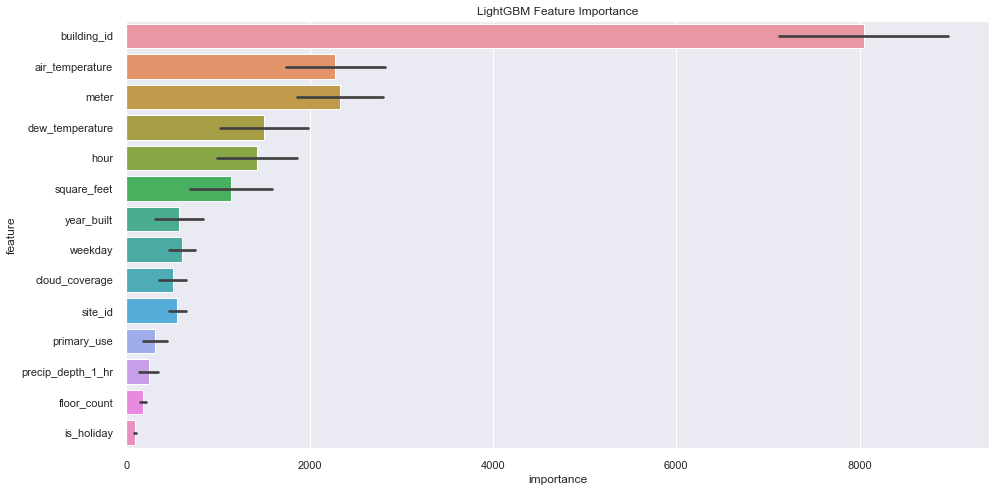

In [26]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()
#plt.savefig('half_feat_importance.png')

In [27]:
del X_train, y_train, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, df_fimp_1, df_fimp_2, df_fimp
gc.collect()

4457

## Preparing test data
Preparing test data with same features as train data. The only difference is that there is no target to transform.

In [28]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test, parse_dates=['timestamp'])

df_test = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 9.78 MB
Decreased by 48.6%


In [29]:
del df_test, building, weather_test
gc.collect()

53

## Scoring test data
Using each half model to predict and then averaging predictions

In [ ]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

## Submission
Preparing final file for submission. Clip minimum values by zero and write output file

In [21]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)